<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab2_Electron/blob/main/Lab2_Thomson2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab2 Electron in fields, Part III: data analysis

Evgeny Kolonsky, Apr - May 2023

[Part I](https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/Lab2_Thomson.ipynb): Reproduce vendor's experiments.

[Part II](https://github.com/evgeny-kolonsky/Lab2_Electron/tree/main/CollectData) Collect data.

In [2]:
import numpy as np # math functions
import pandas as pd
import scipy # scientific functions
from scipy.stats import linregress 
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt 
import requests
from bs4 import BeautifulSoup
import re
import skimage
import numpy.polynomial.polynomial as poly
import itertools

Literature value 
$$
{e_0\over m_0} = 1.7588 \cdot 10^{11} {C \over \text{kg}}
$$

In [3]:
N = 320 # Helmholz ring coils
R = 6.7e-2 # Helmholz ring raduis
mu0 = scipy.constants.mu_0
k2 = (4/5)**1.5
d = 5.5e-2
em_reference = 1.7588e11 # C/kg 

UA_MIN = 2.0e3 #kV Ua acceleration voltage should be big enough, > 2kV. Explained below.
I_MIN = 0.15 # Current should be big enough, > 0.15 A. Explained below




## Define class and read data

In [4]:
url = r'https://raw.githubusercontent.com/evgeny-kolonsky/Lab2_Electron/main/CollectData/'
github_url = 'https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/CollectData/'

class observation:
    num = 0
    Ua = 0
    Up = 0
    I = 0
    x = np.array([])
    y = np.array([])
    image = 0
    pngname = ''
    group = ''
    p = 0 # polynomial approximation
    curvature = 0 #  = 1/r, r - radius
    k1 = 0 # E = k1 * Up/d, losses
    
    
    def __init__(self, num, group, Ua, Up, I, x, y):
        self.num = num
        self.group  = group
        self.Ua = Ua
        self.Up = Up
        self.I = I
        self.x = x
        self.y = y
        self.fit()

    def get_image(self):
        self.pngname = pngfiles[self.num]
        self.image = skimage.io.imread(url + self.pngname)
        
    def fit(self):
        self.p = poly.Polynomial.fit(self.x, self.y, deg=3)
        p1 = self.p.deriv(1)
        p2 = self.p.deriv(2)
        self.curvature = np.abs(p2(self.x) / (1 + p1(self.x)**2) **1.5).mean()
        if self.Up != 0:
          yu = self.y /self.Up
          xu = self.x**2 /4/self.Ua/d
          lr = linregress(xu, yu)
          self.k1 = lr.slope

        
        
        
        
#images
soup = BeautifulSoup(requests.get(github_url).text, 'html.parser')
pngfiles = {}
for i in soup.find_all(title=re.compile("\.png$")):
        fname = i.extract().get_text()
        s = fname[:3]
        if s.isdigit():
            pngfiles[int(s)] = fname.replace(' ', '%20')


#experiments
file = 'experiments.csv'
params = pd.read_csv(url + file, index_col='Num')

#datapoints
measurements = ''
file = 'data.txt'
text = requests.get(url+file).text.splitlines()
for line in text:
  ns, xs, ys = line.split('\t')
  if ns != '':
    num = int(ns)
    Ua = params.loc[num]['Ua']
    Up = params.loc[num]['Up']
    I = params.loc[num]['I']
    continue
  else:
    x = np.float32(xs)
    y = np.float32(ys)
  measurements += f'{num} {x} {y} {Ua} {Up} {I}\n'

data = np.genfromtxt(measurements.splitlines(), dtype=float)

num, x, y, Ua, Up, I = data.T

Ua = Ua*1e3 #kV
Up = Up*1e3 #kV
x = x*1e-2 # cm
y = y*1e-2 # cm

#objects

experiment = {}
for n in np.unique(num):
  filter = (num == n)
  x_ = x[filter]
  y_ = y[filter]
      
  Ua_ = Ua[filter][0]
  Up_ = Up[filter][0]
  I_  = I[filter][0]

  if (Up_ == 0) & (I_ == 0):
    group = 'Z' # Zero forces
  elif (Up_ != 0) & (I_ == 0): 
    group = 'E' # Electron in electrostatic field
  elif (Up_ == 0) & (I_ != 0): 
    group = 'B' # Electron in magnetic field
  else:
    group = 'W' # Wien filter

  obs = observation(n, group, Ua_, Up_, I_, x_, y_)
  experiment[n] = obs
  
  

## Sample plot

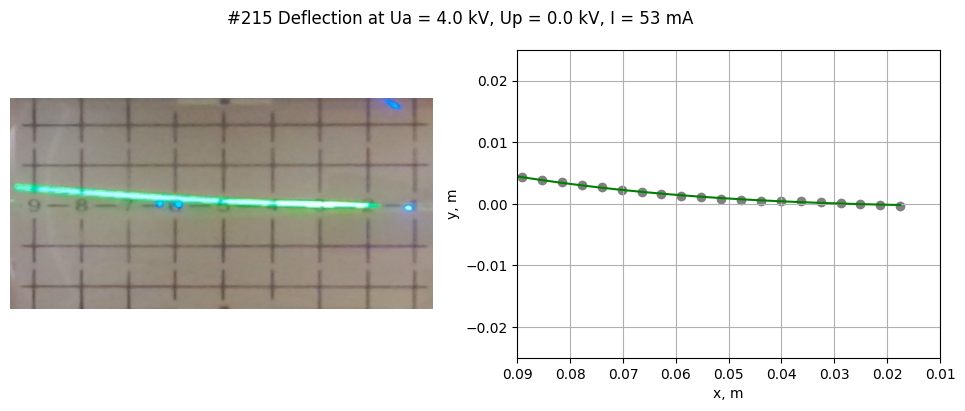

In [5]:
num = 215

x_ = experiment[num].x
y_ = experiment[num].y
p_ = experiment[num].p # polynomial 3rd degree fit
Ua_ = experiment[num].Ua
Up_ = experiment[num].Up
I_ = experiment[num].I


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

fig.suptitle(f'#{num:n} Deflection at Ua = {Ua_*1e-3:.1f} kV, Up = {Up_*1e-3:.1f} kV, I = {I_*1e3:.0f} mA')

experiment[num].get_image()
ax1.imshow(experiment[num].image)
ax1.axis('off')

ax2.scatter(x_, y_, color='gray')
ax2.plot(x_, p_(x_), color='green')
ax2.grid()
plt.xlabel('x, m')
plt.gca().set_xlim([9.e-2, 1.e-2]) # invert direction: from right to left
plt.ylabel('y, m')
plt.gca().set_ylim([-2.5e-2, 2.5e-2])
plt.show();

# Zero correction

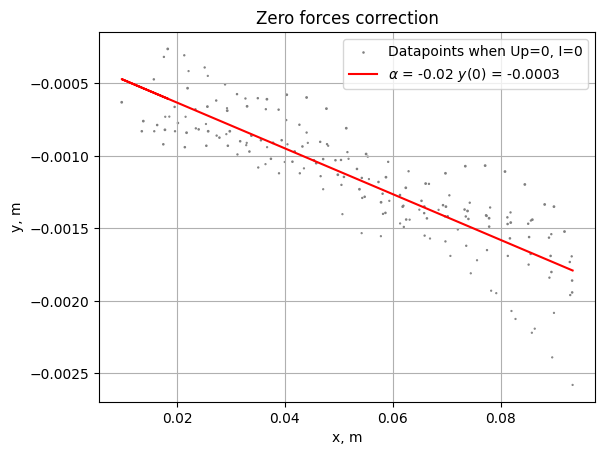

In [6]:
noforces = (Up == 0) & (I == 0)
x_ = x[noforces]
y_ = y[noforces]
Ua_ = Ua[noforces] *1e-3
plt.scatter(x_, y_, marker='.', color = 'gray', 
            s=Ua_,  label='Datapoints when Up=0, I=0')

fit = linregress(x_, y_)
alpha = fit.slope
plt.plot(x_, fit.intercept + fit.slope*x_, color='red', label=fr'$\alpha$ = {alpha:.2f} $y(0)$ = {fit.intercept:.4f} ')
plt.grid()
plt.xlabel('x, m')
plt.ylabel('y, m')
plt.legend()
plt.title('Zero forces correction');


Rotate by $\alpha$ to ensure $y=0$ when no forces applied.

In [7]:
cosa, sina = np.cos(alpha), np.sin(alpha)
x, y = x*cosa + y*sina, -x*sina + y*cosa 

for obs in experiment.values():
  x_, y_ = obs.x, obs.y
  obs.x, obs.y = x_*cosa + y_*sina, -x_*sina + y_*cosa   
  obs.fit()

### Losses $k_1$ sample plot

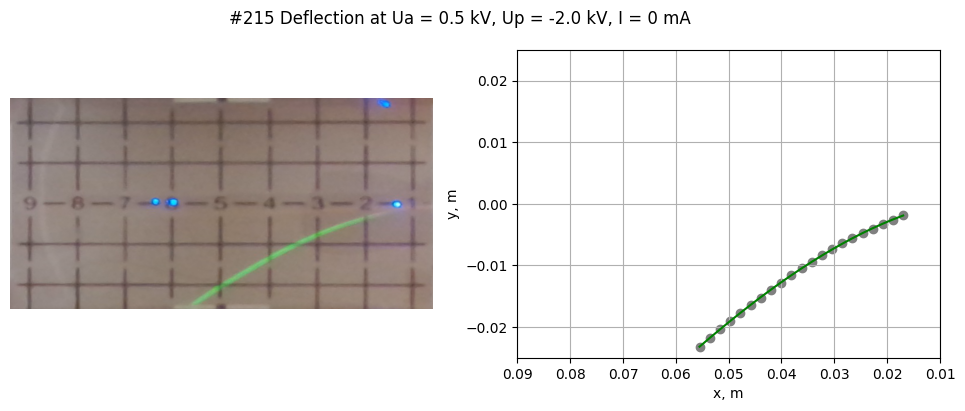

LinregressResult(slope=0.4200718684254224, intercept=9.949103945590178e-08, rvalue=0.9991167342512777, pvalue=1.2677375446001064e-27, stderr=0.004053174830349486, intercept_stderr=6.194913658945762e-08)


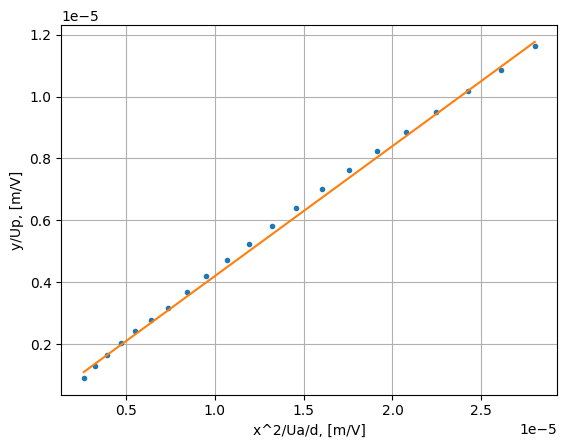

In [8]:
e14 = experiment[5]

x_ = e14.x
y_ = e14.y
p_ = e14.p # polynomial 3rd degree fit
Ua_ = e14.Ua
Up_ = e14.Up
I_ = e14.I


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

fig.suptitle(f'#{num:n} Deflection at Ua = {Ua_*1e-3:.1f} kV, Up = {Up_*1e-3:.1f} kV, I = {I_*1e3:.0f} mA')

e14.get_image()
ax1.imshow(e14.image)
ax1.axis('off')

ax2.scatter(x_, y_, color='gray')
ax2.plot(x_, p_(x_), color='green')
ax2.grid()
plt.xlabel('x, m')
plt.gca().set_xlim([9.e-2, 1.e-2]) # invert direction: from right to left
plt.ylabel('y, m')
plt.gca().set_ylim([-2.5e-2, 2.5e-2])
plt.show();


yu = y_ / Up_
xu = x_**2 /4/Ua_/d
lr = linregress(xu, yu)
print(lr)

plt.plot(xu, yu, '.', label='measurements')
plt.plot(xu, xu*e14.k1, '-', label='k1 fit')
plt.grid()
plt.xlabel('x^2/Ua/d, [m/V]')
plt.ylabel('y/Up, [m/V]')
plt.show()

# E-experiment

num:0, Ua: 0.5 kV, Up: -0.4 kV, k1: 0.752
num:1, Ua: 0.5 kV, Up: -0.6 kV, k1: 0.657
num:2, Ua: 0.5 kV, Up: -0.8 kV, k1: 0.572
num:3, Ua: 0.5 kV, Up: -1.0 kV, k1: 0.530
num:4, Ua: 0.5 kV, Up: -1.5 kV, k1: 0.460
num:5, Ua: 0.5 kV, Up: -2.0 kV, k1: 0.420
num:6, Ua: 0.5 kV, Up: -2.5 kV, k1: 0.386
num:7, Ua: 0.5 kV, Up: -3.0 kV, k1: 0.357
num:8, Ua: 0.5 kV, Up: -3.5 kV, k1: 0.332
num:9, Ua: 0.5 kV, Up: -4.0 kV, k1: 0.310
num:10, Ua: 0.5 kV, Up: -4.5 kV, k1: 0.286
num:11, Ua: 0.5 kV, Up: -5.0 kV, k1: 0.271
num:12, Ua: 0.5 kV, Up: -6.0 kV, k1: 0.246
num:13, Ua: 0.5 kV, Up: -7.0 kV, k1: 0.222
num:14, Ua: 0.5 kV, Up: -8.0 kV, k1: 0.202
num:15, Ua: 0.5 kV, Up: -9.0 kV, k1: 0.186
num:16, Ua: 1.0 kV, Up: -1.0 kV, k1: 0.662
num:17, Ua: 1.0 kV, Up: -1.5 kV, k1: 0.621
num:18, Ua: 1.0 kV, Up: -2.0 kV, k1: 0.553
num:19, Ua: 1.0 kV, Up: -2.5 kV, k1: 0.523
num:20, Ua: 1.0 kV, Up: -3.0 kV, k1: 0.500
num:21, Ua: 1.0 kV, Up: -3.5 kV, k1: 0.475
num:22, Ua: 1.0 kV, Up: -4.0 kV, k1: 0.452
num:23, Ua: 1.0 kV, U

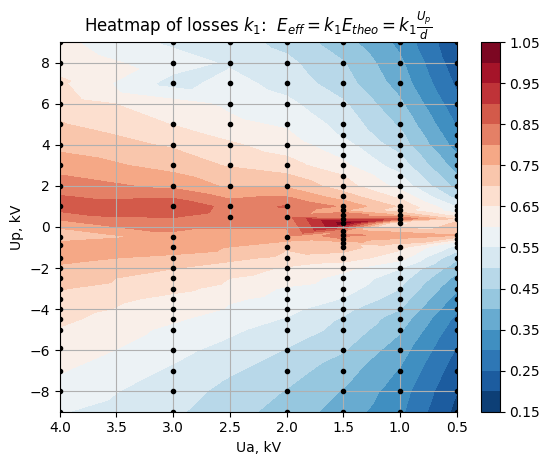

In [9]:
measurements = ''
for obs in experiment.values():
  if obs.group == 'E':
        print(f'num:{obs.num:n}, Ua: {obs.Ua*1e-3:.1f} kV, Up: {obs.Up*1e-3:.1f} kV, k1: {obs.k1:.3f}')
        measurements += f'{obs.Ua} {obs.Up} {obs.k1}\n'

data = np.genfromtxt(measurements.splitlines(), dtype=float)

Ua_, Up_, k1_ = data.T

# could be used instead of constant k1
k1_interp = LinearNDInterpolator(list(zip(Ua_, Up_)), k1_)

Ua_ *= 1e-3 
Up_ *= 1e-3

plt.tricontourf(Ua_, Up_, k1_, levels=19,  cmap="RdBu_r")
plt.plot(Ua_, Up_, 'ko', ms=3)
plt.xlim(4, .5)
plt.grid()
plt.colorbar()
plt.xlabel('Ua, kV')
plt.ylabel('Up, kV')
plt.title(r'Heatmap of losses $k_1$:  $E_{eff} = k_1 E_{theo} = k_1 \frac{U_p}{d}$');

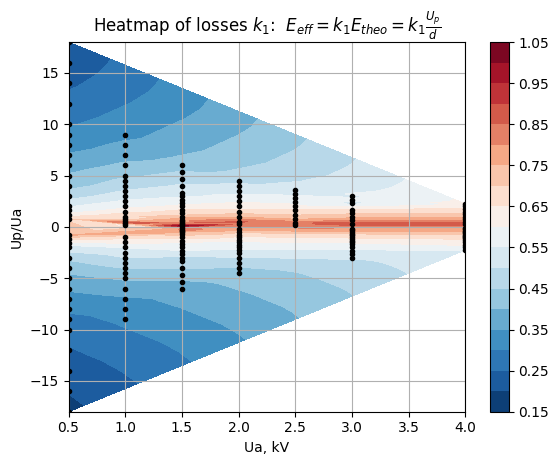

In [10]:
plt.tricontourf(Ua_, Up_/Ua_, k1_, levels=19,  cmap="RdBu_r")
plt.plot(Ua_, Up_/Ua_, 'ko', ms=3)
plt.grid()
plt.colorbar()
plt.xlabel('Ua, kV')
plt.ylabel('Up/Ua')
plt.title(r'Heatmap of losses $k_1$:  $E_{eff} = k_1 E_{theo} = k_1 \frac{U_p}{d}$');

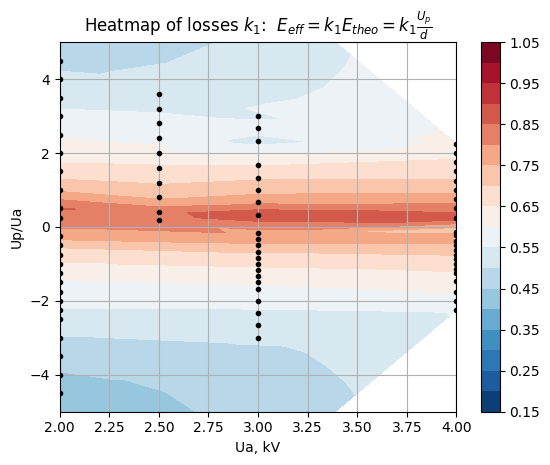

In [11]:
plt.tricontourf(Ua_, Up_/Ua_, k1_, levels=19,  cmap="RdBu_r")
plt.plot(Ua_, Up_/Ua_, 'ko', ms=3)
plt.xlim(2, 4)
plt.ylim(-5, 5)
plt.grid()
plt.colorbar()
plt.xlabel('Ua, kV')
plt.ylabel('Up/Ua')
plt.title(r'Heatmap of losses $k_1$:  $E_{eff} = k_1 E_{theo} = k_1 \frac{U_p}{d}$');

The Loss Coefficient $k_1$ is not a constant $k_1 = 0.75$ for the device, as written by vendor, but changes essentially with $U_a$ and $U_p$. The accuracy of determination ${e \over m}$ depends on ${k_1}^2$ (see section W). To achieve better accuracy of ${e \over m}$ determination, the researcher should either limit parameter's $(U_a, U_p)$ subspace, or consider $k_1$ as a function of $(U_a, U_p)$.

Here we consider $k_1$ as a constant calculated on a parameter's subspace
$$ U_a >= \text{2 kV}.$$

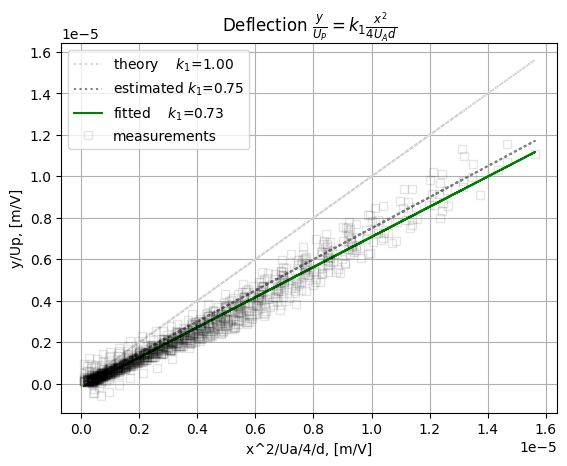

In [12]:
filter =(Up != 0) & (I == 0) # E-experiment
filter = filter * (Ua > UA_MIN) 
#filter = filter *  (np.abs(Up) <= Ua)

x_ = x[filter]
y_ = y[filter]
Up_ = Up[filter]
Ua_ = Ua[filter]
 
xu = x_*x_/Ua_/4/d
yu = y_/Up_


fit = linregress(xu, yu)
k1 = fit.slope

plt.plot(xu, 1.00*xu, label=f'theory    $k_1$={1.0:.2f}',c='lightgray', ls='dotted')
plt.plot(xu, 0.75*xu, label=f'estimated $k_1$={.75:.2f}',c='gray', ls='dotted')
plt.plot(xu, fit.intercept + fit.slope*xu, 
                      label=f'fitted    $k_1$={fit.slope:.2f}',c='green')
plt.plot(xu, yu, label='measurements', c='black', 
            marker='s', fillstyle='none', ls='', alpha=.1)
plt.legend()
plt.grid()
plt.xlabel('x^2/Ua/4/d, [m/V]')
plt.ylabel('y/Up, [m/V]')
plt.title(r'Deflection $\frac{y}{U_P} = k_1 \frac{x^2}{4 U_A d}$');

# B-experiment

### Measure $k_2$ value for the Helmolz rings 

$$ B = k_2 \mu_0 \frac{NI}{R}$$

| direction 1 | direction 2
| :-:         | :-:          
| <img src="https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/helmholz1.jpg?raw=true" width=500> | <img src="https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/helmholz2.jpg?raw=true" width=500> 

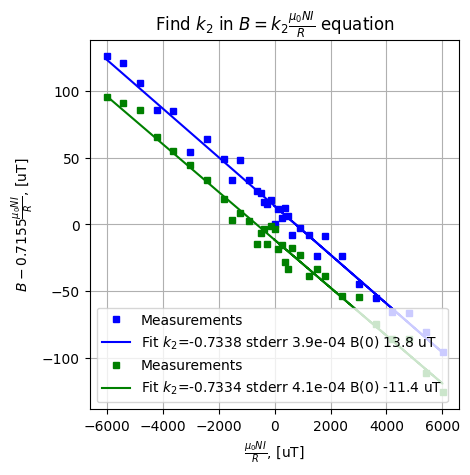

In [13]:
measurements ='''
1 .0     .0 
1 .0236 -.09 
1 .043  -.18 
1 .0634 -.26 
1 .083  -.35 
1 .103  -.45 
1 .153  -.66 
1 .203  -.88 
1 .253 -1.11 
1 .303 -1.31 
1 .402 -1.75 
1 .502 -2.20 
1 .602 -2.64 
1 .702 -3.08 
1 .802 -3.51 
1 .901 -3.95 
1 1.0  -4.39 
1 -.0236 .12 
1 -.043  .20 
1 -.0636 .29 
1 -.083  .38  
1 -.1036 .47  
1 -.153  .69  
1 -.203  .92  
1 -.253 1.12 
1 -.303 1.35  
1 -.402 1.79 
1 -.502 2.21 
1 -.602 2.67 
1 -.702 3.10 
1 -.802 3.55 
1 -.901 3.99 
1 -1.0  4.42  
2 .0     -.003 
2 .0236 -.12 
2 .043  -.20 
2 .0634 -.30 
2 .083  -.39 
2 .103  -.46 
2 .153  -.68 
2 .203  -.91 
2 .253 -1.12 
2 .303 -1.34 
2 .402 -1.78 
2 .502 -2.21 
2 .602 -2.66 
2 .702 -3.10 
2 .802 -3.53 
2 .901 -3.98 
2 1.0  -4.42 
2 -.0236 .10 
2 -.043  .17 
2 -.0636 .27 
2 -.083  .35  
2 -.1036 .43  
2 -.153  .66  
2 -.203  .88  
2 -.253 1.09 
2 -.303 1.32  
2 -.402 1.76 
2 -.502 2.20 
2 -.602 2.64 
2 -.702 3.08 
2 -.802 3.53 
2 -.901 3.96 
2 -1.0  4.39  
'''  

data = np.genfromtxt(measurements.splitlines(), dtype=float)
direction, I, B = data.T
I = I*1 #A
B = B*1e3 #uT
im = mu0*N*I/R *1e6 #uT
k_theor = -.8**1.5
colors = itertools.cycle(('blue', 'green'))

for filter in [direction == 1, direction ==2]:
  I_ = I[filter]
  im_ = im[filter]
  B_ = B[filter]
  clr = next(colors)
  plt.plot(im_, B_ - k_theor *im_, marker='s', ls='', ms=4, c=clr,  label = 'Measurements')
  fit = linregress(im_, B_)
  k2 = fit.slope
  plt.plot(im_, fit.intercept + (k2 - k_theor) *im_, c=clr, 
          label=rf'Fit $k_2$={fit.slope:.4f} stderr {fit.stderr:.1e} B(0) {fit.intercept:.1f} uT')
  
plt.xlabel(r'$\frac{\mu_0 N I}{R}$, [uT]')
plt.ylabel(r'$B - 0.7155 \frac{\mu_0 N I}{R}$, [uT]')
plt.gca().set_box_aspect(1)
plt.grid()
plt.legend()
plt.title(r'Find $k_2$ in $B = k_2  \frac{\mu_0 N I}{R}$ equation');



A bias from zero depends on direction and could be explained by magnetic field of Earth, which is ~30 uT [check here](https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm). 

### Check B-field uniformity in [Helmholz rings](https://en.wikipedia.org/wiki/Helmholtz_coil)

![image](https://upload.wikimedia.org/wikipedia/commons/b/b4/Mplwp_Helmholtz_coil_field.svg)

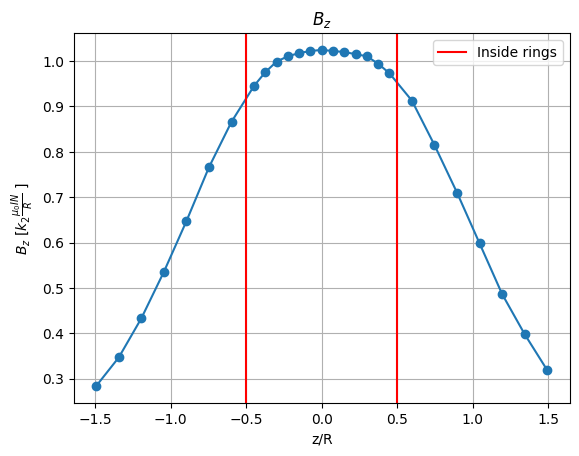

In [14]:
# along z-axis
I_ = 1.00 #A 
measurements = '''
-100 1.22
-90 1.49
-80 1.86
-70 2.30
-60 2.78
-50 3.29
-40 3.72
-30 4.06
-25 4.19
-20   4.29
-15 4.34
-10   4.37
-5   4.39
0 4.40
5 4.39
10 4.38
15 4.36
20 4.34
25 4.27
30 4.18
40 3.92
50 3.50
60 3.05
70 2.57
80 2.09
90 1.71
100 1.37
'''
data = np.genfromtxt(measurements.splitlines(), dtype=float)
z_, B_ = data.T
z_ *= 1e-3 #mm
B_ *= 1e-3 #mT

B_theor = .8**1.5 * mu0 *N *I_ /R

z_ /= R
B_ /= B_theor

plt.plot(z_, B_, 'o-')
plt.xlabel('z/R')
# plt.xlim(-.5, .5)
plt.axvline(x=-.5, color='red', label='Inside rings')
plt.axvline(x=.5, color='red')
plt.ylabel(r'$B_z$ [$k_2 \frac{\mu_0 I N} {R}$ ]')
plt.title('$B_z$')
plt.grid()
plt.legend()


We will use theoretical value of $k_2 = 0.7155$.

In [15]:
#k2 = np.abs(linregress(im, B).slope)
#print(f'k2 = {k2:.3f}')

### B-experiment analysis

$$
B =  k_2 \cdot \mu_0 {N I\over R},
\tag{4}
$$

$$
{e \over m} = {2U_A\over (B\cdot r)^2},
\tag{5}
$$ 

$$
\text{curvature} = {1\over r} = {y'' \over (1 + y'^2)^{3\over 2}}
$$ 


num:200, Ua: 1.0 kV, I: 50 mA, r: 51.0 cm, B:-0.220 mT, em:1.59e+11 C/kg
num:201, Ua: 1.0 kV, I: 100 mA, r: 25.2 cm, B:-0.440 mT, em:1.63e+11 C/kg
num:202, Ua: 1.0 kV, I: 150 mA, r: 16.6 cm, B:-0.660 mT, em:1.66e+11 C/kg
num:203, Ua: 1.0 kV, I: 200 mA, r: 10.7 cm, B:-0.880 mT, em:2.24e+11 C/kg
num:204, Ua: 1.0 kV, I: 250 mA, r: 9.4 cm, B:-1.100 mT, em:1.88e+11 C/kg
num:205, Ua: 2.0 kV, I: 50 mA, r: 74.7 cm, B:-0.220 mT, em:1.48e+11 C/kg
num:206, Ua: 2.0 kV, I: 100 mA, r: 34.9 cm, B:-0.440 mT, em:1.69e+11 C/kg
num:207, Ua: 2.0 kV, I: 150 mA, r: 22.0 cm, B:-0.660 mT, em:1.90e+11 C/kg
num:208, Ua: 2.0 kV, I: 200 mA, r: 19.6 cm, B:-0.880 mT, em:1.34e+11 C/kg
num:209, Ua: 2.0 kV, I: 250 mA, r: 15.6 cm, B:-1.100 mT, em:1.35e+11 C/kg
num:210, Ua: 3.0 kV, I: 50 mA, r: 86.6 cm, B:-0.220 mT, em:1.65e+11 C/kg
num:211, Ua: 3.0 kV, I: 100 mA, r: 48.8 cm, B:-0.440 mT, em:1.30e+11 C/kg
num:212, Ua: 3.0 kV, I: 150 mA, r: 26.6 cm, B:-0.660 mT, em:1.94e+11 C/kg
num:213, Ua: 3.0 kV, I: 200 mA, r: 21.7 cm

(1.943263707009386, 0.5669814005949149)

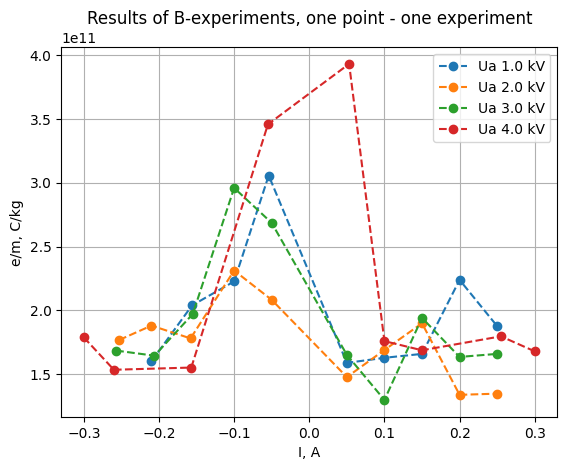

In [16]:
measurements =''
for obs in experiment.values():
  if obs.group == 'B':
    B = k2 * mu0 * N /R * obs.I 
    r = 1/ obs.curvature

    em = 2*obs.Ua /(B * r)**2
    print(f'num:{obs.num:n}, Ua: {obs.Ua*1e-3:.1f} kV, I: {obs.I*1e3:-.0f} mA, r: {r*1e2:.1f} cm, B:{B*1e3:.3f} mT, em:{em:.2e} C/kg')
    measurements += f'{obs.Ua} {obs.I} {em} {B}\n'

data = np.genfromtxt(measurements.splitlines(), dtype=float)
data = data[data[:, 1].argsort()] # sort by I

Ua_, I_, em_, B_, = data.T

for option in np.unique(Ua_):
  plt.plot(I_[Ua_==option],em_[Ua_==option], 'o--', label=f'Ua {option*1e-3:.1f} kV')

plt.legend()
plt.xlabel('I, A')
plt.ylabel('e/m, C/kg')
plt.grid()
plt.title('Results of B-experiments, one point - one experiment')


print('\ne/m *e-11 C/kg, std deviation')
np.mean(em_*1e-11), np.std(em_*1e-11)


We see anomaly near $I=0$: Non-Symmetry at zero point and some increase of $e/m$. Can it be explained by the Earth magnetic field? 

### Earth magnetic field influence

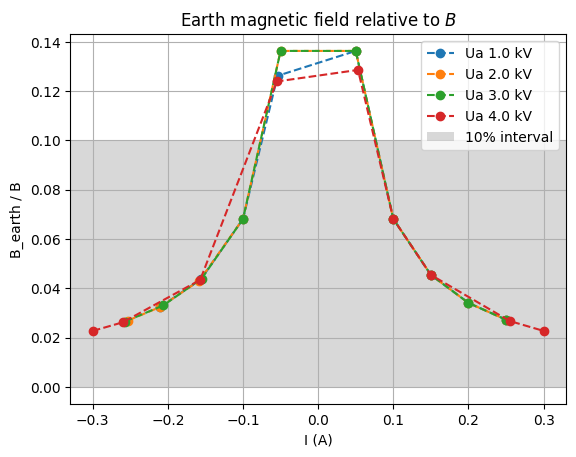

In [17]:
B_earth = 30e-6 #uT
fig, ax = plt.subplots()

for option in np.unique(Ua_):
  plt.plot(I_[Ua_==option],np.abs(B_earth /B_[Ua_==option]) , 'o--', label=f'Ua {option*1e-3:.1f} kV')

ax.axhspan(0, .1, alpha=.3, facecolor='.5', label='10% interval')

plt.legend()
ax.set(xlabel='I (A)', ylabel='B_earth / B', title='Earth magnetic field relative to $B$')
ax.grid()
plt.show();


For small $I$ the relative influence of $B_{earth}$ to $B$ becomes big enough to spoil the results accuracy. The researcher should keep $B$ more than ten times of $B_{earth}$. For pair of Helmholz rings used in the experiment currents should be not less that 100 - 150 mA. 

# W-experiment

In the experiment a velocity filter (Wien filter) is set up. For
the fixed anode voltage $U_A$ the voltage at the plate capacitor
$U_P$ and the current through the Helmholtz pair of coils $I$ is
selected in such a way that the deflections from the electric
and the magnetic fields just cancel each other out at the
outlet of the plate capacitor. If $U_A$ and therefore speed of the
electron is changed, it is apparent that this
compensation without a change of $U_P$ and $I$ is only possible at
a speed of $v=\sqrt{2 e U_A \over m}$ and that the electron beam is
deflected once again. Only by changing $U_P$ or $I$ can the
deflection be compensated for again.

In addition this setup allows more precise determination of
the specific electron charge. When $U_P$ and $I$ are chosen in
such a way that the electric and the magnetic field exactly
compensate the specific charge is
$$
{m v^2 \over 2} = e \cdot U_A , \quad v = {E \over B}
$$

$$
{e \over m} = {1\over 2 U_A} \left({E\over B}\right)^2
\tag{7.1}
$$


On account of the tube construction, the electric field is
smaller than the value to be expected theoretically. This can
be taken into account in the experiment by a correction factor:
$$
E_{exp} = k_1 E_{theo} = k_1 {U_P\over d}
\tag{7.2}$$


In [32]:
measurements = ''
k1 = .75
k2 = 0.7155
for obs in experiment.values():
  if obs.group == 'W':
    #if (obs.Ua > UA_MIN) and (np.abs(obs.Up) <= obs.Ua):
    if (obs.Ua > UA_MIN) and (obs.I > I_MIN):
      B_ = k2 * mu0 * N /R * obs.I 
      #k1 = k1_interp(obs.Ua, obs.Up).tolist()
      E_ = k1 *obs.Up / d
      v_ = np.abs(E_ / B_)
      em_ = 1/2/obs.Ua * v_**2
      print(f'num:{obs.num:n}, Ua: {obs.Ua*1e-3:.1f} kV, Up: {obs.Up*1e-3:.1f} kV I: {obs.I*1e3:-.0f} mA, r: {1/obs.curvature*1e2:.1f} cm, v: {v_:.1e} m/c, em:{em_:.2e} C/kg')
      measurements += f'{obs.Ua} {obs.I} {em_} {B_} {E_} {v_}\n'

data = np.genfromtxt(measurements.splitlines(), dtype=float)
Ua, I, em, B, E, v = data.T

print('\n e/m 1e-11 C/kg, std deviation')
np.mean(em*1e-11), np.std(em*1e-11)


num:318, Ua: 3.0 kV, Up: -2.0 kV I: 201 mA, r: 55.0 cm, v: 3.2e+07 m/c, em:1.66e+11 C/kg
num:319, Ua: 3.0 kV, Up: -3.0 kV I: 303 mA, r: 39.1 cm, v: 3.1e+07 m/c, em:1.65e+11 C/kg
num:321, Ua: 4.0 kV, Up: -3.0 kV I: 257 mA, r: 57.2 cm, v: 3.7e+07 m/c, em:1.72e+11 C/kg
num:322, Ua: 4.0 kV, Up: -4.0 kV I: 343 mA, r: 43.9 cm, v: 3.7e+07 m/c, em:1.71e+11 C/kg

 e/m 1e-11 C/kg, std deviation


(1.6857468396373676, 0.03065311397048655)

# Conclusion: the blueprint of student's experiment 

1. Make **Z**-experiment to record the beam line at zero deflection forces. This will be used later when performing W-experiment.

2. Make **E**-experiment using $U_a$ > 2 kV (variant: $U_p < U_a$). Compare trajectory with parabola. At this experiment researcher finds or checks losses coefficient $k_1$ (passport value $k_1 =0.75$), which will be used later when performing W-experiment.

3. Make **B**-experiment using $I$ > 100 mA. Compare trajectory with circle. Calculate $e/m$ with confidence intervals and compare with literature value ${e_0\over m_0} = 1.7588 \cdot 10^{11} {C \over \text{kg}}$. At this experiment researcher uses $k_2$ theoretical value $k_2 =0.7155$.

4. Make **W**-experiment using $U_a$ > 2 kV and $I$ > 100 mA. At this experiment  researcher sets $U_p$ and varies $I$ to make beam as close to zero-forces line (found earlier) as possible. Calculate $e/m$, confidence interval, and compare the result with literature value and results of B-experiment.    

## PS. Electron velocity

Classic theory

$$
\frac{mv^2}{2} = e U_a, \rightarrow v =\sqrt{2 \frac{e}{m} U_a} $$

In [53]:
Ua = 4e3 #kV
c = scipy.constants.c
# intial speed of electron
v0 = np.sqrt(2*em_reference *Ua)
print(f'v0: {v0:.3e} m/c')
print(f'v0/c: {v0/c:.3f}')

v0: 3.751e+07 m/c
v0/c: 0.125


Relativistic effect [(source)](https://virtuelle-experimente.de/en/kanone/relativistisch/relativistisch.php) 
$$
v_{rel} = c \cdot \sqrt{1 - \frac{1}{\left( 1+ \frac{U_a e}{m c^2}\right)^2}}
$$

In [54]:
v_rel = c * np.sqrt(1 - 1/(1+Ua/c/c*em_reference)**2) 

print(f'v_rel: {v_rel:.3e} m/c')
print(f'v_rel/v0: {v_rel/v0:.3f}')

v_rel: 3.729e+07 m/c
v_rel/v0: 0.994
